In [1]:
# General Data Cleaning/Stats
import pandas as pd
import numpy as np
import re

from datetime import datetime

# General Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk # conda install -c anaconda nltk
from textblob import TextBlob
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/Chin2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Chin2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Chin2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Chin2/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
sns.set_palette("rocket")
pal = sns.color_palette("rocket")
hex_colors = pal.as_hex()
print(hex_colors)
pal

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

## 1. Data Preparation

### Read Dataset

In [3]:
df_reviews = pd.read_csv('data/full_restaurant_review_data.csv', parse_dates=['date'])

### Clean Dataset

In [4]:
def extract_integer(x):
    if not pd.isna(x):
        int_match = re.search("\d+\,*\d*", x)
        if int_match:
            match = int_match.group()
            if "," in match:
                output = match.split(",")[0] + match.split(",")[1]
                return int(output)
            else:
                return int(match)
    return np.nan

def extract_date_of_visit(x):
    if not pd.isna(x):
        match = re.search(r'\bvisit:\s.+', x)
        if match:
            dov = match.group()
            dov = dov.replace('visit: ', '').strip()
            return datetime.strptime(dov, '%B %Y')
    return pd.NaT

def count_number_of_tokens(x):
    if not pd.isna(x):
        return len(x.split(" "))
    return 0

def concat_title_and_description(x, y):
    if pd.isna(x):
        return y
    elif pd.isna(y):
        return x
    elif pd.isna(x) and pd.isna(y):
        return ''
    else:
        return x + ' ' + y    

In [5]:
df_reviews['rating'] = df_reviews['rating'].apply(lambda x: extract_integer(x) / 10)

df_reviews['num_of_img_uploaded'] = df_reviews['img_src'].apply(
    lambda x: len([i for i in x.replace('[', '').replace(']', '').split("',") if i != ""]) if not pd.isna(x) else np.nan
)

df_reviews['date_of_visit'] = df_reviews[['date','date_of_visit']].apply(
    lambda x: extract_date_of_visit(x['date_of_visit']) if not pd.isna(extract_date_of_visit(x['date_of_visit'])) else x['date'], axis=1
)

df_reviews.drop(columns=['img_src'], inplace=True)

df_reviews['full_review'] = df_reviews[['title', 'description']].apply(
    lambda x: concat_title_and_description(x['title'], x['description']), axis=1
)

df_reviews['num_of_tokens_title'] = df_reviews['title'].apply(count_number_of_tokens)
df_reviews['num_of_tokens_description'] = df_reviews['description'].apply(count_number_of_tokens)
df_reviews['num_of_tokens_full_review'] = df_reviews['full_review'].apply(count_number_of_tokens)

### Assigning Sentiment using TextBlob Sentiment Analyzer

In [6]:
df_reviews['title'] = df_reviews['title'].str.replace("\n","").str.strip()
df_reviews['description'] = df_reviews['description'].str.replace("\n","").str.strip()
df_reviews['full_review'] = df_reviews['full_review'].str.replace("\n","").str.strip()

In [7]:
# will take quite a while (~ 5 min)
df_reviews['title_sentiment'] = df_reviews['title'].apply(lambda x: TextBlob(x).sentiment.polarity if not pd.isna(x) else np.nan)
df_reviews['description_sentiment'] = df_reviews['description'].apply(lambda x: TextBlob(x).sentiment.polarity if not pd.isna(x) else np.nan)
df_reviews['full_review_sentiment'] = df_reviews['description'].apply(lambda x: TextBlob(x).sentiment.polarity if not pd.isna(x) else np.nan)

In [11]:
# 1 or 0 based on description sentiment
df_reviews['review_sentiment_category'] = df_reviews['full_review_sentiment'].apply(
    lambda x: 1 if x > 0.05 else 0
)

In [14]:
df_reviews.head(2)

,rating,date,title,description,date_of_visit,url,num_of_img_uploaded,full_review,num_of_tokens_title,num_of_tokens_description,num_of_tokens_full_review,title_sentiment,description_sentiment,full_review_sentiment,review_sentiment_category
0,3.0,2021-12-04,Actually ordered online with Deliveroo! disapp...,Ordered a chicken Cobb salad which is meant to...,2021-12-01,https://www.tripadvisor.com.sg/Restaurant_Revi...,0,Actually ordered online with Deliveroo! disapp...,6,61,67,-0.30,-0.3625,-0.3625,0
1,1.0,2021-01-26,Hate to write bad reviews but....,"Bad service, bad attitude of owner and average...",2021-01-01,https://www.tripadvisor.com.sg/Restaurant_Revi...,0,"Hate to write bad reviews but.... Bad service,...",6,16,22,-0.75,-0.1300,-0.1300,0


In [21]:
df_reviews.shape

(404703, 15)

### Filter for Restaurant in Final Dataset

In [19]:
df_restaurant = pd.read_csv("data/extended_restaurant_rating_data.csv")

In [22]:
df_reviews = df_reviews.merge(df_restaurant[["url"]], how="right", on="url")

In [23]:
df_reviews.shape

(400941, 15)

In [25]:
df_reviews.to_csv("data/final_restaurant_review_data.csv", encoding="utf-8-sig", index=False)

### Groupby Restaurant

In [26]:
df_reviews_groupby_restaurant = df_reviews.groupby(['url']).agg({
    'url': ['count'],
    'rating': ['mean'],
    'title_sentiment': ['mean'],
    'description_sentiment': ['mean'],
    'num_of_tokens_title': ['mean'],
    'num_of_tokens_description': ['mean'],
    'num_of_img_uploaded': ['sum'],
    'full_review_sentiment': ['sum'],
})

df_reviews_groupby_restaurant.rename(columns={
    'url': 'num_of_written_reviews',
}, inplace=True)
df_reviews_groupby_restaurant.columns = df_reviews_groupby_restaurant.columns.droplevel(1)
df_reviews_groupby_restaurant.reset_index(drop=False, inplace=True)
df_reviews_groupby_restaurant.rename(columns={
    'rating': 'average_review_rating',
    'title_sentiment':'average_title_sentiment',
    'description_sentiment':'average_description_sentiment',
    'num_of_tokens_title':'average_title_length',
    'num_of_tokens_description':'average_description_length',
    'full_review_sentiment':'num_of_positive_sentiment'
}, inplace=True)

In [27]:
df_reviews_groupby_restaurant['proportion_of_positive_sentiment'] = df_reviews_groupby_restaurant['num_of_positive_sentiment'] / df_reviews_groupby_restaurant['num_of_written_reviews']

In [28]:
df_reviews_groupby_restaurant

,url,num_of_written_reviews,average_review_rating,average_title_sentiment,average_description_sentiment,average_title_length,average_description_length,num_of_img_uploaded,num_of_positive_sentiment,proportion_of_positive_sentiment
0,https://www.tripadvisor.com.sg/Restaurant_Revi...,367,4.697548,0.493038,0.372978,3.980926,71.820163,335.0,136.883108,0.372978
1,https://www.tripadvisor.com.sg/Restaurant_Revi...,38,4.342105,0.398871,0.321809,3.868421,48.552632,16.0,12.228746,0.321809
2,https://www.tripadvisor.com.sg/Restaurant_Revi...,91,3.549451,0.196038,0.177798,4.197802,52.131868,38.0,16.179600,0.177798
3,https://www.tripadvisor.com.sg/Restaurant_Revi...,10,3.500000,0.251429,0.144984,3.700000,66.100000,10.0,1.449841,0.144984
4,https://www.tripadvisor.com.sg/Restaurant_Revi...,5,4.200000,0.230000,0.191819,5.800000,76.800000,4.0,0.959097,0.191819
...,...,...,...,...,...,...,...,...,...,...
7187,https://www.tripadvisor.com.sg/Restaurant_Revi...,88,3.568182,0.255304,0.298161,4.806818,67.113636,39.0,26.238153,0.298161
7188,https://www.tripadvisor.com.sg/Restaurant_Revi...,33,3.606061,0.209561,0.203068,4.151515,64.848485,37.0,6.701230,0.203068
7189,https://www.tripadvisor.com.sg/Restaurant_Revi...,32,3.187500,0.180990,0.195591,4.250000,51.781250,7.0,6.258911,0.195591
7190,https://www.tripadvisor.com.sg/Restaurant_Revi...,3,4.333333,0.501389,0.296032,3.000000,45.333333,0.0,0.888095,0.296032


## 2. EDA on Reviews

### EDA (Restaurant level)

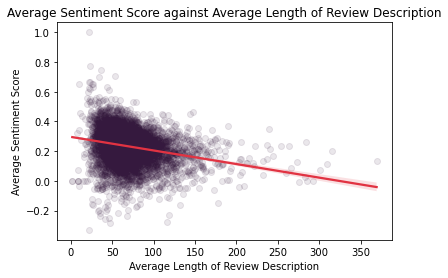

In [29]:
ax = sns.regplot(
    data = df_reviews_groupby_restaurant,
    x = 'average_description_length', 
    y = 'average_description_sentiment',
    line_kws={'color': hex_colors[3]}, scatter_kws= {'alpha': 0.1}
)
ax.set_title("Average Sentiment Score against Average Length of Review Description")
ax.set_ylabel("Average Sentiment Score")
ax.set_xlabel("Average Length of Review Description")

plt.show()


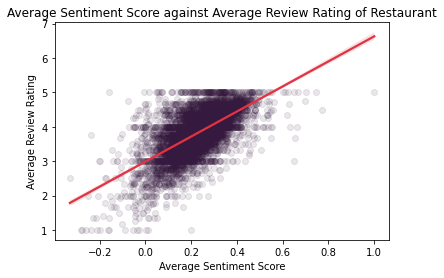

In [30]:
ax = sns.regplot(
    data = df_reviews_groupby_restaurant,
    x = 'average_description_sentiment', 
    y = 'average_review_rating',
    line_kws={'color': hex_colors[3]}, scatter_kws= {'alpha': 0.1}
)
ax.set_title("Average Sentiment Score against Average Review Rating of Restaurant")
ax.set_ylabel("Average Review Rating")
ax.set_xlabel("Average Sentiment Score")

plt.show()


### EDA (Review level)

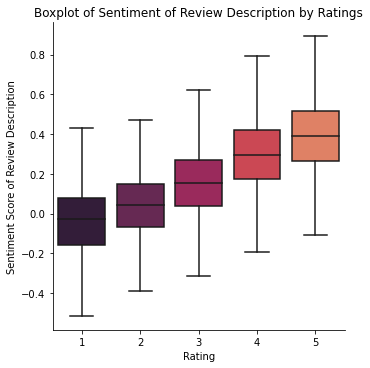

In [31]:

ax = sns.catplot(
    x = 'rating',
    y = 'description_sentiment',
    data = df_reviews,
    kind='box',
    order=[1, 2, 3, 4, 5],
    # palette={True: hex_colors[5], False:hex_colors[1]},
    sym=""
)

ax.fig.gca().set_title(f"Boxplot of Sentiment of Review Description by Ratings")
ax.fig.gca().set_ylabel(f"Sentiment Score of Review Description")
ax.fig.gca().set_xlabel("Rating")
plt.show()

### Visualising Wordcloud of Reviews of Different Rating

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [33]:
df_reviews_one = df_reviews[df_reviews['rating'] == 1]
df_reviews_two = df_reviews[df_reviews['rating'] == 2]
df_reviews_three = df_reviews[df_reviews['rating'] == 3]
df_reviews_four = df_reviews[df_reviews['rating'] == 4]
df_reviews_five = df_reviews[df_reviews['rating'] == 5]

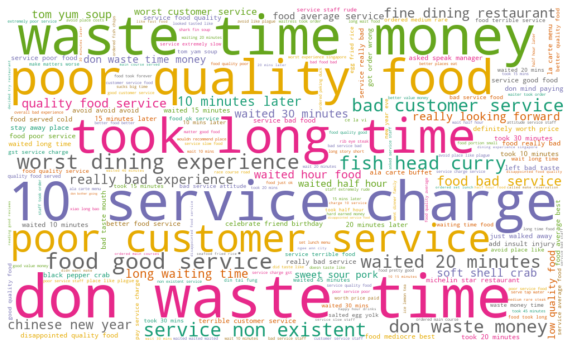

In [34]:
vect = CountVectorizer(
    min_df = 15,
    ngram_range=(3,4),
    lowercase=True,
    stop_words='english',
)

vectors = vect.fit_transform(df_reviews_one['description'])
countvect_df = pd.DataFrame(vectors.toarray(), columns= vect.get_feature_names_out())
sum_df = countvect_df.sum()
df_one_star_tokens = sum_df.reset_index(drop=False)
df_one_star_tokens.rename(columns={'index': 'token', 0:'count'}, inplace=True)
df_one_star_tokens = df_one_star_tokens[df_one_star_tokens['token'] != 'marina bay sands']

d = {}

for a, x in df_one_star_tokens.values:
    d[a] = x

wordcloud = WordCloud(height=600, width=1000, background_color='white', colormap='Dark2')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

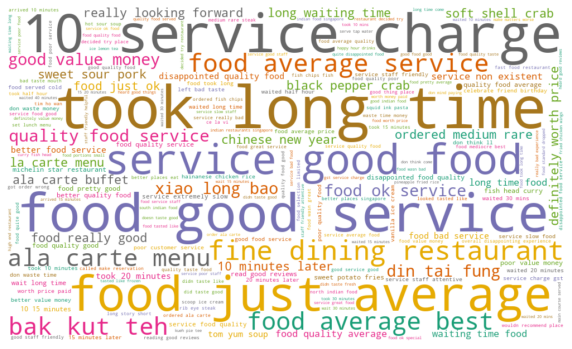

In [35]:
vect = CountVectorizer(
    min_df = 15,
    ngram_range=(3,4),
    lowercase=True,
    stop_words='english',
)

vectors = vect.fit_transform(df_reviews_two['description'])
countvect_df = pd.DataFrame(vectors.toarray(), columns= vect.get_feature_names_out())
sum_df = countvect_df.sum()
df_two_star_tokens = sum_df.reset_index(drop=False)

df_two_star_tokens.rename(columns={'index': 'token', 0:'count'}, inplace=True)
df_two_star_tokens = df_two_star_tokens[df_two_star_tokens['token'] != 'marina bay sands']

d = {}

for a, x in df_two_star_tokens.values:
    d[a] = x

wordcloud = WordCloud(height=600, width=1000, background_color='white', colormap='Dark2')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

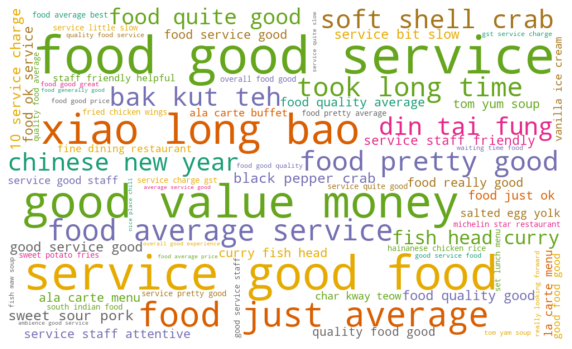

In [36]:
vect = CountVectorizer(
    min_df = 50,
    ngram_range=(3,4),
    lowercase=True,
    stop_words='english',
)

vectors = vect.fit_transform(df_reviews_three['description'])
countvect_df = pd.DataFrame(vectors.toarray(), columns= vect.get_feature_names_out())
sum_df = countvect_df.sum()
df_three_star_tokens = sum_df.reset_index(drop=False)

df_three_star_tokens.rename(columns={'index': 'token', 0:'count'}, inplace=True)
df_three_star_tokens = df_three_star_tokens[df_three_star_tokens['token'] != 'marina bay sands']

d = {}

for a, x in df_three_star_tokens.values:
    d[a] = x

wordcloud = WordCloud(height=600, width=1000, background_color='white', colormap='Dark2')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

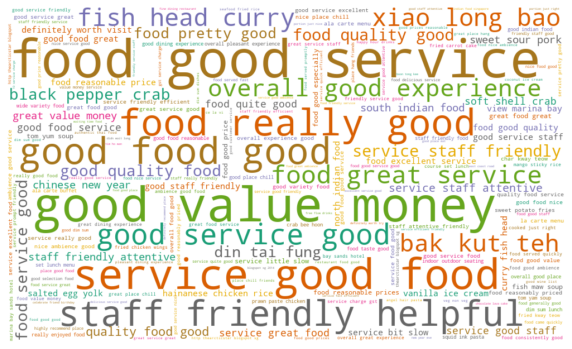

In [37]:
vect = CountVectorizer(
    min_df = 50,
    ngram_range=(3,4),
    lowercase=True,
    stop_words='english',
)

vectors = vect.fit_transform(df_reviews_four['description'])
countvect_df = pd.DataFrame(vectors.toarray(), columns= vect.get_feature_names_out())
sum_df = countvect_df.sum()
df_four_star_tokens = sum_df.reset_index(drop=False)

df_four_star_tokens.rename(columns={'index': 'token', 0:'count'}, inplace=True)
df_four_star_tokens = df_four_star_tokens[df_four_star_tokens['token'] != 'marina bay sands']

d = {}

for a, x in df_four_star_tokens.values:
    d[a] = x

wordcloud = WordCloud(height=600, width=1000, background_color='white', colormap='Dark2')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

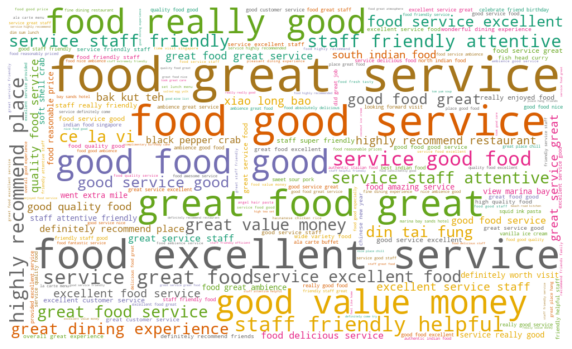

In [38]:
vect = CountVectorizer(
    min_df = 50,
    ngram_range=(3,4),
    lowercase=True,
    stop_words='english',
)

vectors = vect.fit_transform(df_reviews_five['description'])
countvect_df = pd.DataFrame(vectors.toarray(), columns= vect.get_feature_names_out())
sum_df = countvect_df.sum()
df_five_star_tokens = sum_df.reset_index(drop=False)

df_five_star_tokens.rename(columns={'index': 'token', 0:'count'}, inplace=True)
df_five_star_tokens = df_five_star_tokens[df_five_star_tokens['token'] != 'marina bay sands']

d = {}

for a, x in df_five_star_tokens.values:
    d[a] = x

wordcloud = WordCloud(height=600, width=1000, background_color='white', colormap='Dark2')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Some Sample Draft NLP Codes that might be useful

In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression

In [40]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(re.sub('\.|,', '', t)).strip() for t in nltk.word_tokenize(articles)]

In [41]:
stop_words = stopwords.words('english')
tokenized_stop_words = [nltk.word_tokenize(t)[0] for t in stop_words]

In [47]:
tokenizer = LemmaTokenizer()
vect = TfidfVectorizer(
    use_idf = True,
    smooth_idf= True,
    min_df = 1,
    max_df = 0.9,
    lowercase=True,
    stop_words=tokenized_stop_words,
    tokenizer=tokenizer
)

lr_model = LogisticRegression()

lr_pipeline = Pipeline([
    ("vectorizer", vect),
    ("model", lr_model)
])

In [64]:
# df_reviews["rating_group"] = df_reviews["rating"].apply(lambda x: 1 if x > 3 else 0)

# X_train, X_test, Y_train, Y_test = train_test_split(df_reviews['full_review'], df_reviews['rating_group'], test_size=0.3, random_state=2022, shuffle=True)
# model_fit = lr_pipeline.fit(X_train, Y_train)

# coefs = lr_pipeline.named_steps["model"].coef_
# coefs.tolist()
# feature_names = lr_pipeline.named_steps["vectorizer"].get_feature_names()
# coefs_and_features = list(zip(coefs, feature_names))

# print('Most Positive Tokens:')
# print(sorted(coefs_and_features, key=lambda x: x[0], reverse=True))[:10]
# print('Most Negative Tokens:')
# print(sorted(coefs_and_features, key=lambda x: x[0]))[:10]

# prediction = model_fit.predict(X_test)
# score = model_fit.score(X_test, Y_test)
# print("accuracy: %.2f%%" % score)